In [48]:
# importing libraries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt

import emoji
import re
import requests
import numpy as np
import contractions
import pandas as pd
import plotly.express as px
import plotly
import plotly.graph_objects as go
import seaborn as sns
import ipywidgets as widgets
import gensim
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

clear_output(wait=True)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lwant\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lwant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


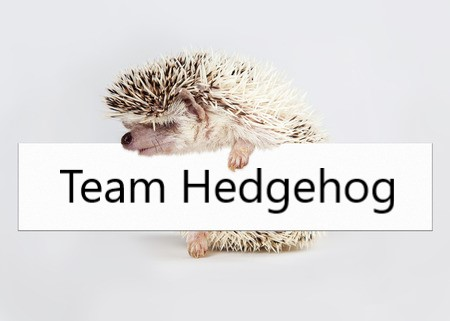

In [56]:
from IPython.display import Image
Image(filename='hedge.jpg') 

**Index:**
1. <a id='activity'>Reddit Submission Activity based on Term, by Subreddit</a>
2. <a id='frequency'>Frequency of Ticker mentions in r/wallstreetbets</a>
3. <a id='sentiment'>Sentiment Score of Ticker mentions in r/wallstreetbets</a>
4. <a id='ppo'>PPO (between 5v20d) of Ticker</a>
5. <a id='hv'>Historical Volatility of Ticker</a>
6. <a id='vpt'>VPT of Ticker Closing Price & Volume</a>
7. <a id='scorecard'>Scorecard</a>

In [3]:
# a couple of helper functions

def get_pushshift_data(data_type, **kwargs):
    """
    Gets data from the pushshift api.
    
    Data type can be 'comment' or 'submission'
    The rest of the args as interpreted as payload.
    
    Read more: https://github.com/pushshift/api
    """
    
    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    payload = kwargs
    
    request = requests.get(base_url, params=payload)
    
    return request.json()


def make_clickable(val):
    """
    Makes a pandas column clickable.
    """
    
    return '<a href="{}">Link</a>'.format(val)

[Reddit Submission Activity based on Term, by Subreddit](#activity)


In [4]:
fig = go.FigureWidget( layout=go.Layout() )
def plot_reddit_submission_activity(ticker):

    data = get_pushshift_data(data_type="submission", q=ticker, after="24h", size=500, aggs="subreddit").get("data")

    df = pd.DataFrame.from_records(data).value_counts("subreddit")[0:10]

    x_data = df.keys()
    y_data = df.values
    
    dict_of_fig = dict({
        "data": [{"type": "bar",
                  "x": x_data,
                  "y": y_data}],
        "layout": {"title": {"text": "Subreddits with most activity - submissions with " + ticker + " in the last 24h",}, "xaxis_title": "Subreddit", "yaxis_title": "No. of Submissions"}
    })

    fig = go.Figure(dict_of_fig)

    fig.show()

In [5]:
interact(plot_reddit_submission_activity, ticker='GME')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='GME', description='ticker'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

In [6]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer as SIA

def get_sentiment(sia, text):
    if sia.polarity_scores(text)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(text)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"
    
sia = SIA()  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lwant\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
from gensim.utils import simple_preprocess
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [8]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy 
spacy.load('en_core_web_sm')

stop_words = stopwords.words('english')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lwant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
fig = go.FigureWidget( layout=go.Layout() )
def plot_reddit_title_sentiment(ticker):
    labels = ['Neutral','Positive','Negative']
    colors = ['blue', 'green', 'red']
    mode_size = [8]
    line_size = [5]
    
    data = get_pushshift_data(q=ticker, data_type="submission", after="24h", size=500, sort_type="score", sort="desc", subreddit="wallstreetbets").get("data")
    df = pd.DataFrame.from_records(data)[["title", "created_utc","permalink"]]
    
    data = df.title.tolist()
    data = [re.sub('\s+', ' ', str(sent)) for sent in data]
    data = [re.sub(r"(?:\@|https?\://)\S+", "", str(sent)) for sent in data]
    data = [emoji.demojize(str(sent), delimiters=("", " ")) for sent in data]
    data = [re.sub('[\s]+', ' ', str(sent)) for sent in data]
    data = [re.sub(r'\b(\w+)( \1\b)+', r'\1', str(sent)) for sent in data]
    data = [contractions.fix(str(sent)) for sent in data]
    data = [re.sub(r"\b\d+\b", " ", str(sent)) for sent in data]
    data = [re.sub(r'[^\x00-\x7F]+',"'", str(sent)) for sent in data]
    data = [re.sub(r'[^\w]|_',' ', str(sent)) for sent in data]
    data = [re.sub(r'\bgamestop\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bgamestops\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bgamestonk\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bgalaxy\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bmelvin\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\brocket\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bmoon\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bmooning\b', 'gme', str(sent)) for sent in data]
    data = [re.sub('[\s]+', ' ', str(sent)) for sent in data]
    data = [str(sent).lower() for sent in data] 
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_data = [[lemmatizer.lemmatize(ch, get_wordnet_pos(ch)) for ch in word] for word in (data_words_nostops)]
    string_data =  [' '.join(sent) for sent in lemmatized_data]
    df['cleaned_title'] = string_data

    df['Sentiment'] = df['cleaned_title'].apply(lambda x : get_sentiment(sia, str(x)))
    df['compound'] = [sia.polarity_scores(str(x))['compound'] for x in df['cleaned_title']]
    df['neg'] = [sia.polarity_scores(str(x))['neg'] for x in df['cleaned_title']]
    df['neu'] = [sia.polarity_scores(str(x))['neu'] for x in df['cleaned_title']]
    df['pos'] = [sia.polarity_scores(str(x))['pos'] for x in df['cleaned_title']]
    
    values = df['Sentiment'].value_counts(normalize=True)
    
    dict_of_fig = dict({
        "data": [{"type": "pie",
                  "labels": labels,
                  "values": values,
                  "marker": {'colors': ['#e6f2ff', '#38F29D', '#F30000']},
                  "textinfo":"percent+label"}],
        "layout": {"title": {"text": "r/wallstreetbets sentiment - submissions with " + ticker + " in the last 24h",}}
    })

    fig = go.Figure(dict_of_fig)

    fig.show()

In [11]:
def sentiment_value(ticker):
    ticker = 'gme'
    data = get_pushshift_data(q=ticker, data_type="submission", after="24h", size=500, sort_type="score", sort="desc", subreddit="wallstreetbets").get("data")
    df = pd.DataFrame.from_records(data)[["title", "created_utc","permalink"]]
    
    data = df.title.tolist()
    data = [re.sub('\s+', ' ', str(sent)) for sent in data]
    data = [re.sub(r"(?:\@|https?\://)\S+", "", str(sent)) for sent in data]
    data = [emoji.demojize(str(sent), delimiters=("", " ")) for sent in data]
    data = [re.sub('[\s]+', ' ', str(sent)) for sent in data]
    data = [re.sub(r'\b(\w+)( \1\b)+', r'\1', str(sent)) for sent in data]
    data = [contractions.fix(str(sent)) for sent in data]
    data = [re.sub(r"\b\d+\b", " ", str(sent)) for sent in data]
    data = [re.sub(r'[^\x00-\x7F]+',"'", str(sent)) for sent in data]
    data = [re.sub(r'[^\w]|_',' ', str(sent)) for sent in data]
    data = [re.sub(r'\bgamestop\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bgamestops\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bgamestonk\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bgalaxy\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bmelvin\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\brocket\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bmoon\b', 'gme', str(sent)) for sent in data]
    data = [re.sub(r'\bmooning\b', 'gme', str(sent)) for sent in data]
    data = [re.sub('[\s]+', ' ', str(sent)) for sent in data]
    data = [str(sent).lower() for sent in data] 
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_data = [[lemmatizer.lemmatize(ch, get_wordnet_pos(ch)) for ch in word] for word in (data_words_nostops)]
    string_data =  [' '.join(sent) for sent in lemmatized_data]
    df['cleaned_title'] = string_data

    df['Sentiment'] = df['cleaned_title'].apply(lambda x : get_sentiment(sia, str(x)))
    df['compound'] = [sia.polarity_scores(str(x))['compound'] for x in df['cleaned_title']]
    df['neg'] = [sia.polarity_scores(str(x))['neg'] for x in df['cleaned_title']]
    df['neu'] = [sia.polarity_scores(str(x))['neu'] for x in df['cleaned_title']]
    df['pos'] = [sia.polarity_scores(str(x))['pos'] for x in df['cleaned_title']]
    
    values = df['Sentiment'].value_counts(normalize=True)
    
    signal =''
    if values['Positive']>0.3:
        signal = 1
    else:
        signal = 0
    
    return signal

[Sentiment Score of Ticker mentions in r/wallstreetbets](#sentiment)

In [12]:
interact(plot_reddit_title_sentiment, ticker='GME')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='GME', description='ticker'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

[Frequency of Ticker mentions in r/wallstreetbets](#frequency)

In [13]:
fig = go.FigureWidget( layout=go.Layout() )
def plot_reddit_ticker_frequency(ticker):

    data = get_pushshift_data(q=ticker, data_type="submission", after="24h", size=500, sort_type="score", sort="desc", subreddit="wallstreetbets").get("data")
    df = pd.DataFrame.from_records(data)[["title"]]
    count=len(df.index)
    
    dict_of_fig = dict({
        "data": [{"type": "indicator",
                  "value": count,
                  "delta": {'reference': 311.666667},
                  "mode" : "number+delta+gauge",
                 }],
        "layout": {"template": {"data": {'indicator': [{
        'title': "Frequency of submissions with " + ticker + " mentioned in the last 24h"}]}
        }}})

    fig = go.Figure(dict_of_fig)

    fig.show()

In [14]:
def frequency_value(ticker):
    data = get_pushshift_data(q=ticker, data_type="submission", after="24h", size=500, sort_type="score", sort="desc", subreddit="wallstreetbets").get("data")
    df = pd.DataFrame.from_records(data)[["title"]]
    count=len(df.index)
    
    signal=''
    if count>311.67:
        signal = 1
    else:
        signal = 0
    return signal

In [15]:
interact(plot_reddit_ticker_frequency, ticker='GME')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='GME', description='ticker'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

In [16]:
from pandas_datareader import data
import datetime
import ta

In [17]:
fig = go.FigureWidget( layout=go.Layout() )
def plot_VPT(ticker):

    start_date = '2020-01-01'
    end_date = datetime.datetime.now()

    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
    close = panel_data['Close']
    volume = panel_data['Volume']
    panel_data['VPT'] =ta.volume.volume_price_trend(close, volume)
    ma_long_VPT = panel_data[('VPT')].rolling(window=5).mean()
    panel_data['moving_average'] = ma_long_VPT
    panel_data['change_alert'] = ((panel_data['VPT']-panel_data['moving_average']))
    
    latest_value=panel_data['change_alert'].iloc[-1]
    
    dict_of_fig = dict({
        "data": [{"type": "indicator",
                  "value": latest_value,
                  "delta": {'reference': 2e+07},
                  "mode" : "number+delta+gauge",
                 }],
        "layout": {"template": {"data": {'indicator': [{
        'title': "VPT Percentage Change Alert for " + ticker}]}
        }}})

    fig = go.Figure(dict_of_fig)

    fig.show()

In [18]:
def vpt_value(ticker):
    start_date = '2020-01-01'
    end_date = datetime.datetime.now()

    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
    close = panel_data['Close']
    volume = panel_data['Volume']
    panel_data['VPT'] =ta.volume.volume_price_trend(close, volume)
    ma_long_VPT = panel_data[('VPT')].rolling(window=5).mean()
    panel_data['moving_average'] = ma_long_VPT
    panel_data['change_alert'] = ((panel_data['VPT']-panel_data['moving_average']))
    
    latest_value=panel_data['change_alert'].iloc[-1]
    
    signal =''
    if latest_value>2e+07:
        signal = 1
    else:
        signal = 0
    return signal

[VPT of Ticker Closing Price & Volume](#vpt)

In [20]:
interact(plot_VPT, ticker='GME')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='GME', description='ticker'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

In [21]:
fig = go.FigureWidget( layout=go.Layout() )
def plot_hv(ticker):
    
    start_date = '2020-01-01'
    end_date = datetime.datetime.now()

    panel_data_1d = data.DataReader(ticker, 'yahoo', start_date, end_date)
    close_1d = panel_data_1d['Close']
    hv_days_v1 = 5
    hv_v1 = np.sqrt(252) * pd.DataFrame.rolling(np.log(close_1d / close_1d.shift(1)),window=hv_days_v1).std()
    hv_merge = close_1d.to_frame().merge(hv_v1, left_index=True, right_index=True, how='left')
    hv_merge.columns = [ticker + str(' Price'), str(hv_days_v1) + 'D HV']
    hv_merge['Threshold Value'] = hv_merge[str(hv_days_v1) + 'D HV']
    hv_merge['Trigger Alert 2'] = np.where(hv_merge[str(hv_days_v1) + 'D HV'] >= 2.0, True, False)
    
    latest_value=hv_merge['Threshold Value'].iloc[-1]

    
    dict_of_fig = dict({
        "data": [{"type": "indicator",
                  "value": latest_value,
                  "delta": {'reference': 2.0},
                  "mode" : "number+delta+gauge",
                 }],
        "layout": {"template": {"data": {'indicator': [{
        'title': "HV Trigger Alert for " + ticker}]}
        }}})

    fig = go.Figure(dict_of_fig)

    fig.show()

In [25]:
def hv_value(ticker):
    start_date = '2020-01-01'
    end_date = datetime.datetime.now()

    panel_data_1d = data.DataReader(ticker, 'yahoo', start_date, end_date)
    close_1d = panel_data_1d['Close']
    hv_days_v1 = 5
    hv_v1 = np.sqrt(252) * pd.DataFrame.rolling(np.log(close_1d / close_1d.shift(1)),window=hv_days_v1).std()
    hv_merge = close_1d.to_frame().merge(hv_v1, left_index=True, right_index=True, how='left')
    hv_merge.columns = [ticker + str(' Price'), str(hv_days_v1) + 'D HV']
    hv_merge['Threshold Value'] = hv_merge[str(hv_days_v1) + 'D HV']
    hv_merge['Trigger Alert 2'] = np.where(hv_merge[str(hv_days_v1) + 'D HV'] >= 2.0, True, False)
    
    latest_value=hv_merge['Threshold Value'].iloc[-1]
    
    signal =''
    if latest_value>2.0:
        signal=1
    else:
        signal=0
    return signal

[Historical Volatility of Ticker](#hv)

In [22]:
interact(plot_hv, ticker='GME')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='GME', description='ticker'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

In [23]:
fig = go.FigureWidget( layout=go.Layout() )
def plot_ema(ticker):
    start_date = '2020-01-01'
    end_date = datetime.datetime.now()

    panel_data_1d = data.DataReader(ticker, 'yahoo', start_date, end_date)
    close_1d = panel_data_1d['Close']
    days_v1 = 5
    days_v2 = 20
    sma_v1 = close_1d.rolling(window=days_v1).mean()
    mod_v1_close = close_1d.copy()
    mod_v1_close.iloc[0:days_v1] = sma_v1[0:days_v1]
    ema_v1 = mod_v1_close.ewm(span=days_v1, adjust=False).mean()
    sma_v2 = close_1d.rolling(window=days_v2).mean()
    mod_v2_close = close_1d.copy()
    mod_v2_close.iloc[0:days_v2] = sma_v2[0:days_v2]
    ema_v2 = mod_v2_close.ewm(span=days_v2, adjust=False).mean()
    ema_merge = close_1d.to_frame().merge(ema_v1, left_index=True, right_index=True, how='left')
    ema_merge = ema_merge.merge(ema_v2, left_index=True, right_index=True, how='left')
    ema_merge.columns = [ticker + str(' Price'), str(days_v1) + 'D EMA', str(days_v2) + 'D EMA']
    ema_v1_v2 = (ema_v1 - ema_v2) / ema_v2
    close_1d_merge_trigger = close_1d.to_frame().merge(ema_v1_v2, left_index=True, right_index=True, how='left')
    close_1d_merge_trigger.columns = [ticker + str(' Price'), str(days_v1) + '/' + str(days_v2) + ' D EMA PPO']
    close_1d_merge_trigger['Threshold Value'] = close_1d_merge_trigger[str(days_v1) + '/' + str(days_v2) + ' D EMA PPO']
    close_1d_merge_trigger['Trigger Alert 1'] = np.where(close_1d_merge_trigger[str(days_v1) + '/' + str(days_v2) + ' D EMA PPO'] >= 0.20, True, False)
    
    latest_value=close_1d_merge_trigger['Threshold Value'].iloc[-1]
        
    dict_of_fig = dict({
        "data": [{"type": "indicator",
                  "value": latest_value,
                  "delta": {'reference': 0.2},
                  "mode" : "number+delta+gauge",
                 }],
        "layout": {"template": {"data": {'indicator': [{
        'title': "PPO Trigger Alert for " + ticker}]}
        }}})

    fig = go.Figure(dict_of_fig)

    fig.show()

In [51]:
def plot_jeff(ticker):
    start_date = '2020-01-01'
    end_date = datetime.datetime.now()

    panel_data_1d = data.DataReader(ticker, 'yahoo', start_date, end_date)
    close_1d = panel_data_1d['Close']
    days_v1 = 5
    days_v2 = 20
    sma_v1 = close_1d.rolling(window=days_v1).mean()
    mod_v1_close = close_1d.copy()
    mod_v1_close.iloc[0:days_v1] = sma_v1[0:days_v1]
    ema_v1 = mod_v1_close.ewm(span=days_v1, adjust=False).mean()
    sma_v2 = close_1d.rolling(window=days_v2).mean()
    mod_v2_close = close_1d.copy()
    mod_v2_close.iloc[0:days_v2] = sma_v2[0:days_v2]
    ema_v2 = mod_v2_close.ewm(span=days_v2, adjust=False).mean()
    ema_merge = close_1d.to_frame().merge(ema_v1, left_index=True, right_index=True, how='left')
    ema_merge = ema_merge.merge(ema_v2, left_index=True, right_index=True, how='left')
    ema_merge.columns = [ticker + str(' Price'), str(days_v1) + 'D EMA', str(days_v2) + 'D EMA']
    ema_v1_v2 = (ema_v1 - ema_v2) / ema_v2
    
    # Plot of all comparison between different EMA days
    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(ema_v1_v2.index, ema_v1_v2, label=str(days_v1) + '/' + str(days_v2) + ' D EMA PPO')
    ax.set_title("Percentage Price Oscillator vs Price")
    ax.legend()

    # Twin object for two different y-axis on the sample plot
    ax2 = ax.twinx()
    ax2.plot(close_1d, color='red', label=str(ticker + ' Closing Price'))
    ax2.legend(loc='lower right')
    

In [28]:
def ppo_value(ticker):
    start_date = '2020-01-01'
    end_date = datetime.datetime.now()

    panel_data_1d = data.DataReader(ticker, 'yahoo', start_date, end_date)
    close_1d = panel_data_1d['Close']
    days_v1 = 5
    days_v2 = 20
    sma_v1 = close_1d.rolling(window=days_v1).mean()
    mod_v1_close = close_1d.copy()
    mod_v1_close.iloc[0:days_v1] = sma_v1[0:days_v1]
    ema_v1 = mod_v1_close.ewm(span=days_v1, adjust=False).mean()
    sma_v2 = close_1d.rolling(window=days_v2).mean()
    mod_v2_close = close_1d.copy()
    mod_v2_close.iloc[0:days_v2] = sma_v2[0:days_v2]
    ema_v2 = mod_v2_close.ewm(span=days_v2, adjust=False).mean()
    ema_merge = close_1d.to_frame().merge(ema_v1, left_index=True, right_index=True, how='left')
    ema_merge = ema_merge.merge(ema_v2, left_index=True, right_index=True, how='left')
    ema_merge.columns = [ticker + str(' Price'), str(days_v1) + 'D EMA', str(days_v2) + 'D EMA']
    ema_v1_v2 = (ema_v1 - ema_v2) / ema_v2
    close_1d_merge_trigger = close_1d.to_frame().merge(ema_v1_v2, left_index=True, right_index=True, how='left')
    close_1d_merge_trigger.columns = [ticker + str(' Price'), str(days_v1) + '/' + str(days_v2) + ' D EMA PPO']
    close_1d_merge_trigger['Threshold Value'] = close_1d_merge_trigger[str(days_v1) + '/' + str(days_v2) + ' D EMA PPO']
    close_1d_merge_trigger['Trigger Alert 1'] = np.where(close_1d_merge_trigger[str(days_v1) + '/' + str(days_v2) + ' D EMA PPO'] >= 0.20, True, False)
    
    latest_value=close_1d_merge_trigger['Threshold Value'].iloc[-1]
        
    signal =''
    if latest_value>0.2:
        signal = 1
    else:
        signal = 0
    return signal

[PPO (between 5v20d) of Ticker](#ppo)

In [24]:
interact(plot_ema, ticker='GME')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='GME', description='ticker'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

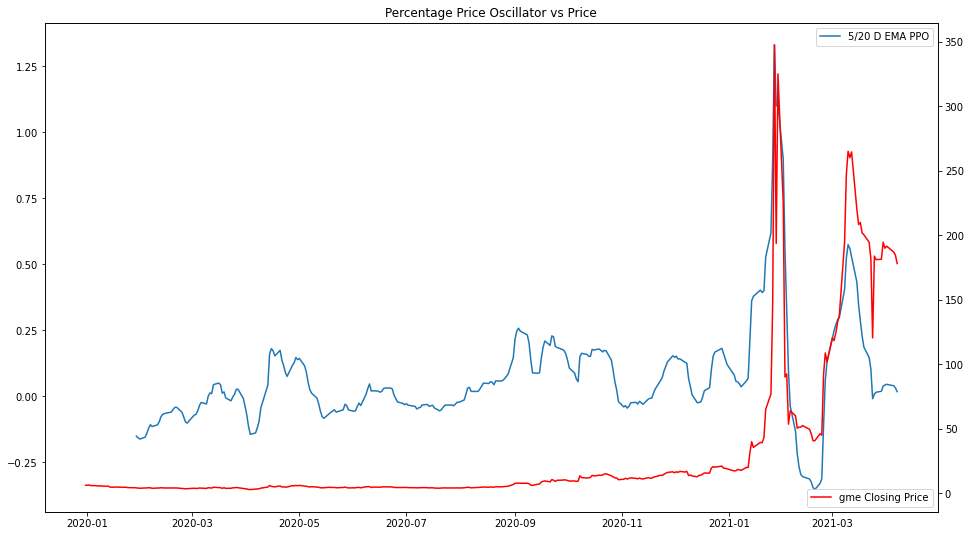

In [53]:
plot_jeff('gme')

[Scorecard](#=scorecard)

In [44]:
fig = go.FigureWidget( layout=go.Layout() )
def scorecard(ticker):
    freq = frequency_value(ticker)
    sentiment = sentiment_value(ticker)
    ppo = ppo_value(ticker)
    hv = hv_value(ticker)
    vpt = vpt_value(ticker)
    overall = 0.11*int(freq)+0.07*int(sentiment)+0.28*int(ppo)+0.27*int(hv)+0.27*int(vpt)
    header = dict(values=['Criteria', 'Alert'])
    values = dict(values=[['Frequency of Ticker mentioned', 'Positive Sentiment Score', 'PPO between 5v20d', 'Historical Volatility', 'VPT of Closing Price & Volume', 'Overall'],[freq,sentiment,ppo,hv,vpt,overall]])
    
    dict_of_fig = dict({
        "data": [{"type": "table",
                  "cells": dict(values),
                  "header": dict(header)}],
        "layout": {"title": {"text": "Scorecard",}, "xaxis_title": "Subreddit", "yaxis_title": "No. of Submissions"}
    })

    fig = go.Figure(dict_of_fig)

    fig.show()

In [45]:
interact(scorecard, ticker='GME')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none' # uncomment this, run cell again - then the graph/figure disappears
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='GME', description='ticker'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …